In [ ]:
%matplotlib inline

In [1]:
import pickle
import random
from collections import defaultdict
from itertools import product

import Orange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

In [2]:
kernels_names = [
    'Katz', 'logKatz',
    'For', 'logFor',
    'Comm', 'logComm',
    'Heat', 'logHeat',
    'NHeat', 'logNHeat',
    'SCT', 'SCCT',
    'RSP', 'FE',
    'PPR', 'logPPR',
    'ModifPPR', 'logModifPPR',
    'HeatPR', 'logHeatPR',
    'DF', 'logDF',
    'Abs', 'logAbs',
    'SP-CT'
]

shuffle = lambda x: sorted(x, key=lambda k: random.random())

def dict_argmax(dct, score_key):
    best_key = list(dct.keys())[0]
    best_val = dct[best_key]
    for k, v in dct.items():
        if v[score_key] > best_val[score_key]:
            best_key, best_val = k, v
    return best_key, best_val

CACHE_ROOT = '../../cache/cache'

def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for dataset, classifier_accuracy in results.items():
        if type(dataset) == tuple:
            dataset = '_'.join([str(x) for x in dataset])
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(accuracies)):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)

# Analyze results of Datasets

In [4]:
DATASETS_RESULTS_ROOT = '../../cache/kkmeans_init_datasets'
datasets = [
    'cora_DB', 'cora_EC', 'cora_HA', 'cora_HCI', 'cora_IR', 'cora_Net',
    'dolphins',
    'eu-core',
    'eurosis',
    'football',
    'karate',
    'news_2cl_1', 'news_2cl_2', 'news_2cl_3',
    'news_3cl_1', 'news_3cl_2', 'news_3cl_3',
    'news_5cl_1', 'news_5cl_2', 'news_5cl_3',
    'polblogs',
    'polbooks',
    'sp_school_day_1', 'sp_school_day_2'
]

In [5]:
with open(f'{CACHE_ROOT}/datasets_inits_bestparam_byari_individual.pkl', 'rb') as f:
    results = pickle.load(f)
with open(f'{CACHE_ROOT}/datasets_modularity.pkl', 'rb') as f:
    modularity_results = pickle.load(f)

datasets_inits_bestparam_byari_individual: cache file ../../cache/cache/datasets_inits_bestparam_byari_individual.pkl found! Skip calculations


In [6]:
# table for modularity any3
results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(datasets, kernels_names):  # {dataset, {kernel_name: best_ari}}
    results_modularity_any3[dataset][kernel_name] = np.mean(results_modularity_any3[dataset][kernel_name])

df = pd.DataFrame(results_modularity_any3)
df.to_excel('./results/datasets_modularity_any3_bestparam_byari_individual.xlsx')
# df

## CD diagram

n_experiments: 3600


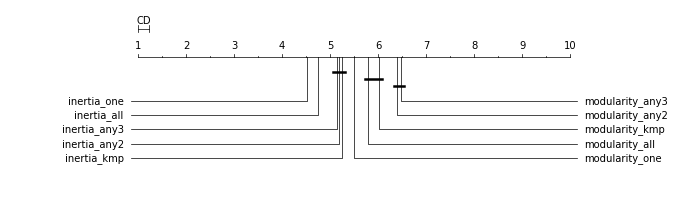

In [7]:
avranks, names, n_experiments = calc_avranks(results) # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

n_experiments: 144


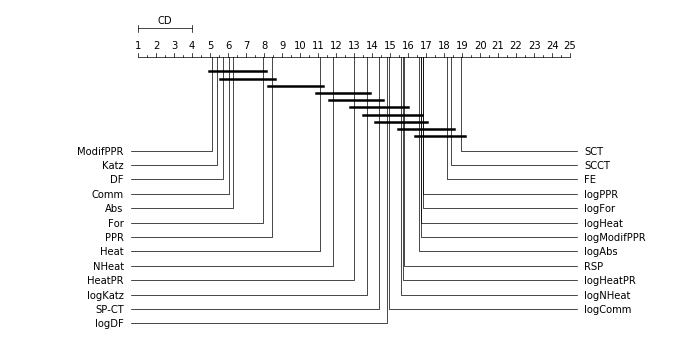

In [8]:
results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

avranks, names, n_experiments = calc_avranks(results_modularity_any3)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

## Group datasets by measure ranking

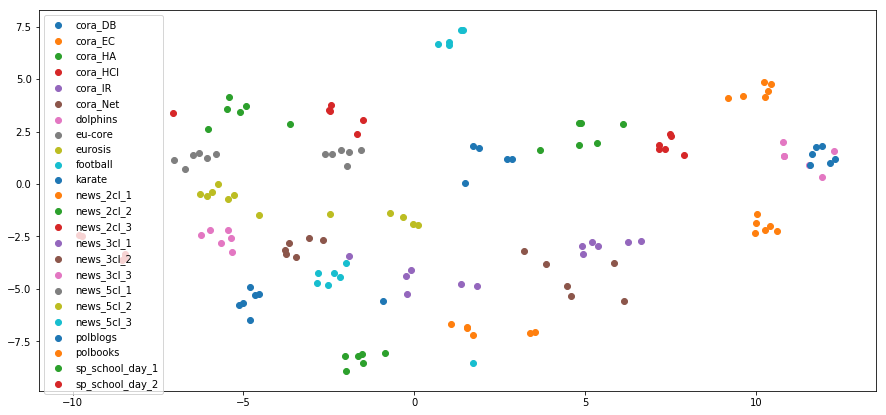

In [9]:
results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {(dataset, graph_idx), {kernel_name: best_ari}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

dataset_graphidx_avranks = dict()
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks({'0': dataset_results})
    dataset_graphidx_avranks[dataset_name] = avranks
    
# TSNE
X_embedded = TSNE(n_components=2, learning_rate=100).fit_transform(list(dataset_graphidx_avranks.values()))

dataset_embedding = defaultdict(list)  # {dataset: [embedding]}
for (dataset, graph_idx), X_embedded_item in zip(list(dataset_graphidx_avranks.keys()), X_embedded):
    dataset_embedding[dataset].append(X_embedded_item)
    
plt.subplots(1, figsize=(15, 7))
for dataset, embedding in dataset_embedding.items():
    embedding = np.array(embedding)
    plt.scatter(embedding[:, 0], embedding[:, 1], label=dataset)
plt.legend()

['cora_DB', 'cora_EC', 'cora_HA', 'cora_HCI', 'cora_IR', 'cora_Net', 'dolphins', 'karate', 'polbooks']
['eu-core', 'eurosis', 'football', 'news_2cl_1', 'news_2cl_2', 'news_2cl_3', 'news_3cl_1', 'news_3cl_2', 'news_3cl_3', 'news_5cl_1', 'news_5cl_2', 'news_5cl_3', 'polblogs', 'sp_school_day_1', 'sp_school_day_2']


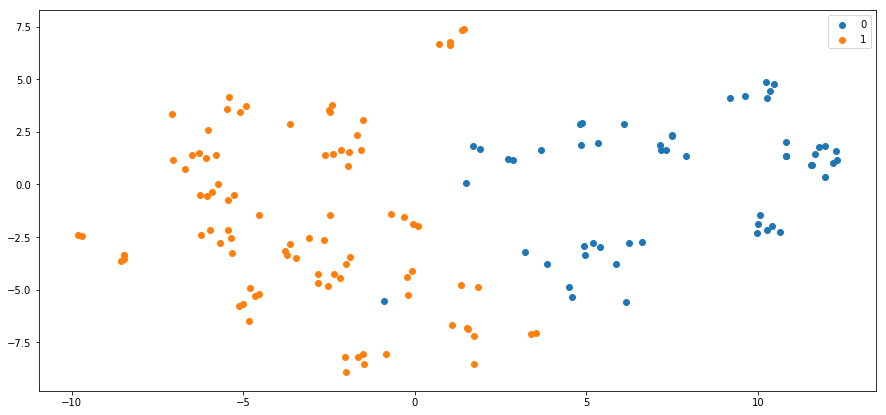

In [10]:
results_modularity_any3 = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  # {dataset: {graphidx: {kernel_name: best_ari}}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[dataset][graph_idx][kernel_name] = si_ari['modularity_any3']

dataset_avranks = dict()  # {dataset: avranks}
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks(dataset_results)
    dataset_avranks[dataset_name] = avranks

n_clusters = 2
# kmeans = KMeans(n_clusters=n_clusters)
kmeans = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
kmeans.fit(list(dataset_avranks.values()))
kmeans.labels_

datasets_partition = []  # [[dataset]]
for class_idx in range(n_clusters):
    datasets = [dataset_name for dataset_name, label in zip(list(dataset_avranks.keys()), kmeans.labels_) if label == class_idx]
    print(datasets)
    datasets_partition.append(datasets)
    
plt.subplots(1, figsize=(15, 7))
for class_idx in range(n_clusters):
    datasets = datasets_partition[class_idx]
    embedding_filtered = []
    for dataset in datasets:
        embedding_filtered.extend(dataset_embedding[dataset])
    embedding_filtered = np.array(embedding_filtered)
    plt.scatter(embedding_filtered[:, 0], embedding_filtered[:, 1], label=class_idx)
plt.legend()

n_experiments: 54


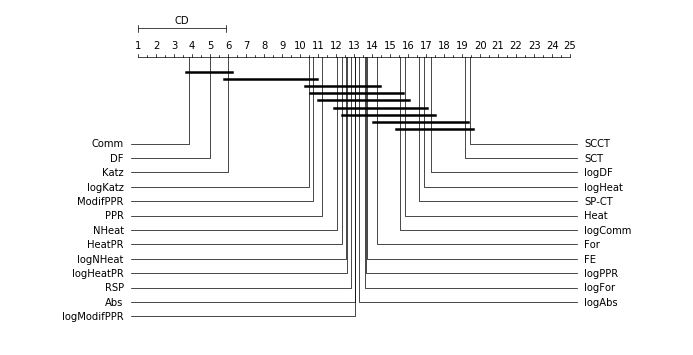

n_experiments: 90


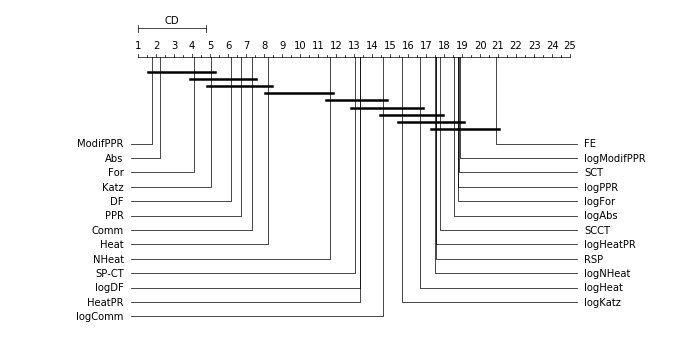

In [11]:
for group_idx, datasets_group in enumerate(datasets_partition):
    results_filtered = {k: v for k, v in results.items() if k[0] in datasets_group}
    results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
    for (dataset, kernel_name, graph_idx), si_ari in results_filtered.items():
        results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

    avranks, names, n_experiments = calc_avranks(results_modularity_any3)
    print(f'n_experiments: {n_experiments}')
    cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
    plt.show()